In [1]:
# Logger
import logging
logging.basicConfig(level=logging.WARN)

# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load PyALCS ACSM module
from bacs.agents.bacs import BACS, Configuration
from bacs.agents.bacs.utils.GymMazeWrapper import _maze_metrics, parse_metrics_to_df, plot_performance

# Load environments
import gym
import my_mazes

## Agent - BACS

### Common parameters

In [2]:
CLASSIFIER_LENGTH = 8
NUMBER_OF_POSSIBLE_ACTIONS = 8

MAZE = "Woods101-v0"

NUMBER_OF_EXPLORE_TRIALS = 1000
DO_ACTION_PLANNING_EXPLORE = False
DO_GA_EXPLORE = False
DO_SUBSUMPTION_EXPLORE = True
BETA_EXPLORE = 0.05
EPSILON = 0.8

NUMBER_OF_EXPLOIT_TRIALS = 500
DO_ACTION_PLANNING_EXPLOIT = False
DO_SUBSUMPTION_EXPLOIT = True
BETA_EXPLOIT = 0.00

LENGTH_OF_BEHAVIORAL_SEQUENCES = 1

### Environment - Maze

In [3]:
# Initialize environment
maze = gym.make(MAZE)
# Reset it, by putting an agent into random position
situation = maze.reset()
# Render the state in ASCII
maze.render()


■ ■ ■ ■ ■ ■ ■
■ □ □ □ □ A ■
■ □ ■ □ ■ □ ■
■ □ ■ $ ■ □ ■
■ ■ ■ ■ ■ ■ ■


### Training of BACS - Exploration

In [4]:
%%time

cfg_explore = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_ga=DO_GA_EXPLORE,
    do_subsumption=DO_SUBSUMPTION_EXPLORE,
    do_action_planning=DO_ACTION_PLANNING_EXPLORE,
    action_planning_frequency=50,
    beta=BETA_EXPLORE,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=EPSILON,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_explore = BACS(cfg_explore)
population_explore, metrics_explore = agent_explore.explore(maze, NUMBER_OF_EXPLORE_TRIALS)

CPU times: user 39.8 s, sys: 207 ms, total: 40 s
Wall time: 40.7 s


In [5]:
population_explore_to_display = [cl for cl in population_explore if cl.does_anticipate_change()]
for cl in population_explore_to_display:
    print(cl)
    #print("{!r} \t {!r} \t {!r} \t {:.3f} \t {:.3f} \t {:.1f} \t {!r} \t {!r}".format(cl.condition, cl.action, cl.effect, cl.fitness, cl.q, cl.talp, cl.exp, cl.mark))
    print("\n")

###010## 2 None None ###101##         (110###01)            q: 0.45  r: 902.5  ir: 0.0    f: 405.7  exp: 441 tga: 7     talp: 28215 tav: 60.1   num: 1


1100100# 5 None None 0011011#         (#######1)            q: 0.476 r: 925.6  ir: 0.0    f: 440.8  exp: 722 tga: 9     talp: 28218 tav: 63.4   num: 1


#0##0### 4 None None #1##1###         (empty)               q: 1.0   r: 471.8  ir: 0.0    f: 471.7  exp: 163 tga: 14    talp: 28165 tav: 1.77e+02 num: 1


11001001 3 None None 00119110         (empty)               q: 0.532 r: 930.2  ir: 0.0    f: 495.0  exp: 300 tga: 27    talp: 28191 tav: 1.29e+02 num: 1


001#9#10 0 None None 110#0#01         (empty)               q: 1.0   r: 902.5  ir: 0.0    f: 902.5  exp: 252 tga: 28    talp: 28234 tav: 1.06e+02 num: 1


110#0#01 4 None None 001#9#10         (empty)               q: 1.0   r: 950.0  ir: 0.0    f: 950.0  exp: 452 tga: 29    talp: 28235 tav: 61.9   num: 1


###0100# 6 None None ###1011#         (110####1)            q: 0.771 r: 902.

### Exploitation of BACS

In [6]:
%%time

cfg_exploit = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_ga=False,
    do_subsumption=DO_SUBSUMPTION_EXPLOIT,
    do_action_planning=DO_ACTION_PLANNING_EXPLOIT,
    action_planning_frequency=50,
    beta=BETA_EXPLOIT,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=1
)

agent_exploit = BACS(cfg_exploit, population_explore)
agent_exploit.clean_population()
population_exploit, metrics_exploit = agent_exploit.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS)

CPU times: user 5.59 s, sys: 32.3 ms, total: 5.62 s
Wall time: 5.74 s


### Performance

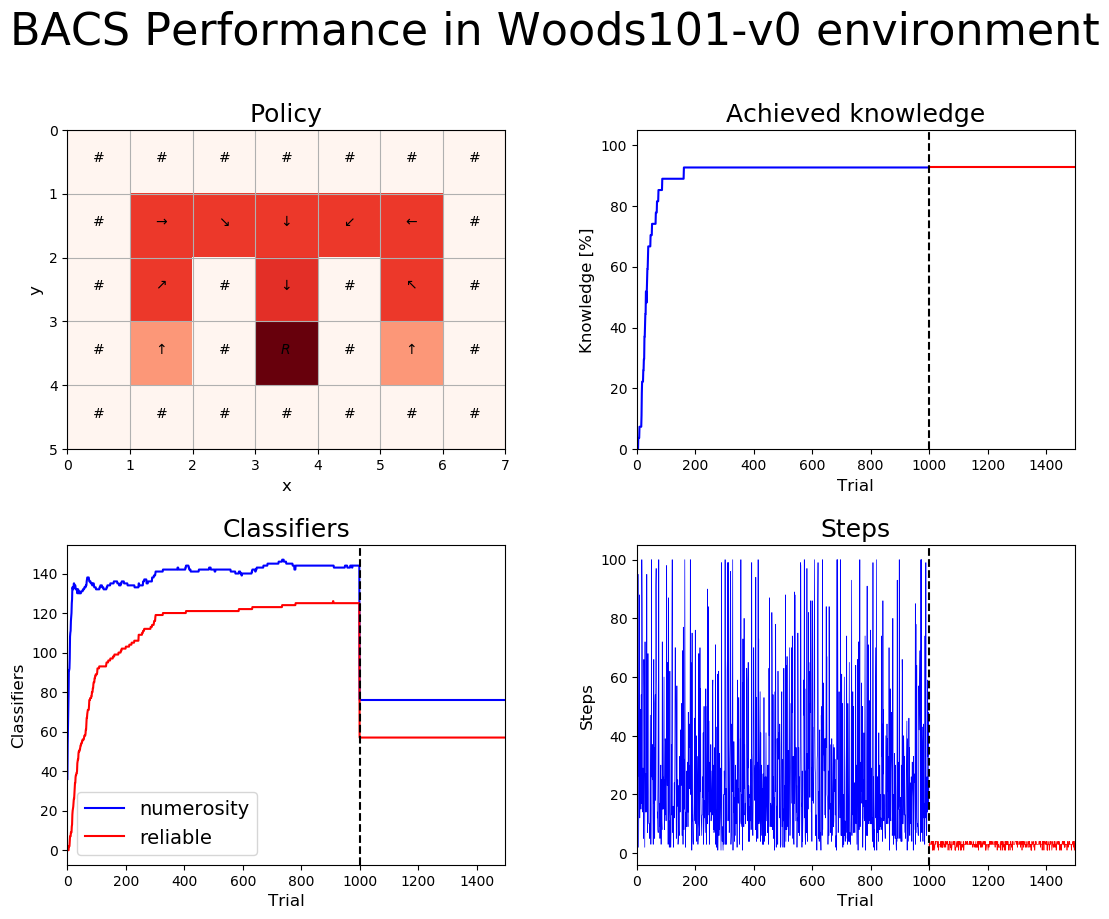

In [7]:
metrics_df = parse_metrics_to_df(metrics_explore, metrics_exploit)
plot_performance(agent_exploit, maze, metrics_df, cfg_exploit, MAZE)

In [8]:
avg_step_explore = 0
for trial in metrics_explore:
    avg_step_explore += trial['steps_in_trial']
avg_step_explore /= NUMBER_OF_EXPLORE_TRIALS
avg_step_exploit = 0
for trial in metrics_exploit:
    avg_step_exploit += trial['steps_in_trial']
avg_step_exploit /= NUMBER_OF_EXPLOIT_TRIALS
print("Average number of steps to solve the maze is ",avg_step_explore,
      " for a total of ", NUMBER_OF_EXPLORE_TRIALS, " trials in EXPLORATION")
print("Average number of steps to solve the maze is ",avg_step_exploit,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS, " trials in EXPLOITATION")

Average number of steps to solve the maze is  28.237  for a total of  1000  trials in EXPLORATION
Average number of steps to solve the maze is  2.974  for a total of  500  trials in EXPLOITATION


In [9]:
population_exploit.sort(key=lambda cl: -cl.fitness)
population_exploit_to_display = [cl for cl in population_exploit]
for cl in population_exploit_to_display:
    print(cl)
    #print("{!r} \t {!r} \t {!r} \t {:.3f} \t {:.3f} \t {:.1f} \t {!r} \t {!r}".format(cl.condition, cl.action, cl.effect, cl.fitness, cl.q, cl.num, cl.exp, cl.mark))
    print("\n")

#0##9##0 4 None None #1##1##1         (empty)               q: 1.0   r: 1e+03  ir: 1e+03  f: 1e+03  exp: 975 tga: 52    talp: 28236 tav: 31.7   num: 1


0011011# 1 [3] [('1', '1', '0', '0', '1', '0', '0', '1')] ####9##0         (empty)               q: 1.0   r: 950.0  ir: 0.0    f: 950.0  exp: 668 tga: 229   talp: 28181 tav: 48.0   num: 1


0#110110 7 [5] [('1', '1', '0', '0', '1', '0', '0', '1')] #0##9###         (empty)               q: 1.0   r: 950.0  ir: 0.0    f: 950.0  exp: 500 tga: 2625  talp: 28197 tav: 62.5   num: 1


110#0#01 4 None None 001#9#10         (empty)               q: 1.0   r: 950.0  ir: 0.0    f: 950.0  exp: 452 tga: 29    talp: 28235 tav: 61.9   num: 1


##11010# 6 [5] [('1', '1', '0', '0', '1', '0', '0', '1')] 00##9#10         (empty)               q: 1.0   r: 950.0  ir: 0.0    f: 950.0  exp: 408 tga: 2252  talp: 28139 tav: 53.0   num: 1


1#1101## 6 [5] [('1', '1', '0', '0', '1', '0', '0', '1')] 00##9#10         (empty)               q: 1.0   r: 950.0  ir: 0.0 